In [1]:
import sys
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensordict.nn import TensorDictModule, TensorDictSequential
from tensordict.nn.distributions import NormalParamExtractor
import torch
from torchrl.collectors import SyncDataCollector
from torch.distributions import Categorical
from torchrl.envs.libs.pettingzoo import PettingZooWrapper
from torchrl.envs.transforms import TransformedEnv, RewardSum
from torchrl.envs.utils import check_env_specs
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.modules import MultiAgentMLP, ProbabilisticActor
from torchrl.objectives.value import GAE
from torchrl.objectives import ClipPPOLoss, ValueEstimators
from tqdm import tqdm
from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import nn
from torchrl._utils import logger as torchrl_logger
from torchrl.collectors import SyncDataCollector
from torchrl.data import TensorDictReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import ExplorationType, set_exploration_type
from torchrl.modules import EGreedyModule, QValueModule, SafeSequential
from torchrl.modules.models.multiagent import MultiAgentMLP, QMixer, VDNMixer
from torchrl.objectives import SoftUpdate, ValueEstimators
from torchrl.objectives.multiagent.qmixer import QMixerLoss
import sys
import os
import json

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))

from RouteRL.keychain import Keychain as kc
from RouteRL.environment.environment import TrafficEnvironment
from RouteRL.services.plotter import Plotter
from RouteRL.utilities import get_params

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [2]:
# Devices
device = (
    torch.device(0)
    if torch.cuda.is_available()
    else torch.device("cpu")
)

print("device is: ", device)
vmas_device = device  # The device where the simulator is run

# Sampling
frames_per_batch = 40  # Number of team frames collected per training iteration
n_iters = 50  # Number of sampling and training iterations - the episodes the plotter plots
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 100  # Number of optimization steps per training iteration
minibatch_size = 2  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients
memory_size = 1000  # Size of the replay buffer
tau =  0.005

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lmbda = 0.9  # lambda for generalised advantage estimation
entropy_eps = 1e-4  # coefficient of the entropy term in the PPO loss

device is:  cpu


#### Environment creation

In [3]:
params = get_params("params.json")

env = TrafficEnvironment(params[kc.RUNNER], params[kc.ENVIRONMENT], params[kc.SIMULATOR], params[kc.AGENT_GEN], params[kc.AGENTS], params[kc.PLOTTER])

env.start()
env.reset()

[CONFIRMED] Environment variable exists: SUMO_HOME
[SUCCESS] Added module directory: C:\Program Files (x86)\Eclipse\Sumo\tools


({}, {})

#### Human learning

In [4]:
num_episodes = 100

for episode in range(num_episodes):
    env.step()

#### Mutation

In [5]:
env.mutation()

In [6]:
machine_list = []
for machines in env.machine_agents:
    machine_list.append(str(machines.id))
      
group = {'agents': machine_list}
      
env = PettingZooWrapper(
    env=env,
    use_mask=True,
    categorical_actions=True,
    done_on_any = False,
    group_map=group,
    device=device
)

In [7]:
print("action_spec:", env.full_action_spec)
print("reward_spec:", env.full_reward_spec)
print("done_spec:", env.full_done_spec)
print("observation_spec:", env.observation_spec)
print("env.group is: ", env.group_map)


action_spec: CompositeSpec(
    agents: CompositeSpec(
        action: DiscreteTensorSpec(
            shape=torch.Size([10]),
            space=DiscreteBox(n=2),
            device=cpu,
            dtype=torch.int64,
            domain=discrete), device=cpu, shape=torch.Size([10])), device=cpu, shape=torch.Size([]))
reward_spec: CompositeSpec(
    agents: CompositeSpec(
        reward: UnboundedContinuousTensorSpec(
            shape=torch.Size([10, 1]),
            space=None,
            device=cpu,
            dtype=torch.float32,
            domain=continuous), device=cpu, shape=torch.Size([10])), device=cpu, shape=torch.Size([]))
done_spec: CompositeSpec(
    done: DiscreteTensorSpec(
        shape=torch.Size([1]),
        space=DiscreteBox(n=2),
        device=cpu,
        dtype=torch.bool,
        domain=discrete),
    terminated: DiscreteTensorSpec(
        shape=torch.Size([1]),
        space=DiscreteBox(n=2),
        device=cpu,
        dtype=torch.bool,
        domain=discr

In [8]:
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
)

In [9]:
check_env_specs(env)


2024-10-02 18:01:39,868 [torchrl][INFO] check_env_specs succeeded!


In [10]:
reset_td = env.reset()


#### Policy network

In [11]:
net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
        n_agent_outputs=env.action_spec.space.n,
        n_agents=env.n_agents,
        centralised=False,
        share_params=True,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=nn.Tanh,
    )

In [12]:
module = TensorDictModule(
        net, in_keys=[("agents", "observation")], out_keys=[("agents", "action_value")]
    )

value_module = QValueModule(
    action_value_key=("agents", "action_value"),
    out_keys=[
        env.action_key,
        ("agents", "action_value"),
        ("agents", "chosen_action_value"),
    ],
    spec=env.action_spec,
    action_space=None,
)

qnet = SafeSequential(module, value_module)

In [13]:
qnet_explore = TensorDictSequential(
        qnet,
        EGreedyModule(
            eps_init=0.3,
            eps_end=0,
            annealing_num_steps=int(total_frames * (1 / 2)),
            action_key=env.action_key,
            spec=env.action_spec,
        ),
    )

In [14]:
mixer = TensorDictModule(
            module=QMixer(
                state_shape=env.observation_spec[
                    "agents", "observation"
                ].shape,
                mixing_embed_dim=32,
                n_agents=env.n_agents,
                device=device,
            ),
            in_keys=[("agents", "chosen_action_value"), ("agents", "observation")],
            out_keys=["chosen_action_value"],
        )

#### Collector

In [15]:
collector = SyncDataCollector(
        env,
        qnet_explore,
        device=device,
        storing_device=device,
        frames_per_batch=frames_per_batch,
        total_frames=total_frames,
    )

#### Replay buffer

In [16]:
replay_buffer = TensorDictReplayBuffer(
        storage=LazyTensorStorage(memory_size, device=device),
        sampler=SamplerWithoutReplacement(),
        batch_size=minibatch_size,
    )

#### Qmix loss function

In [17]:
loss_module = QMixerLoss(qnet, mixer, delay_value=True)
loss_module.set_keys(
    action_value=("agents", "action_value"),
    local_value=("agents", "chosen_action_value"),
    global_value="chosen_action_value",
    action=env.action_key,
)
loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)
target_net_updater = SoftUpdate(loss_module, eps=1 - tau)

optim = torch.optim.Adam(loss_module.parameters(), lr)


#### Training loop

In [18]:
import time

total_time = 0
total_frames = 0
sampling_start = time.time()
for i, tensordict_data in enumerate(collector):
    torchrl_logger.info(f"\nIteration {i}")

    sampling_time = time.time() - sampling_start

    # Remove agent dimension from reward (since it is shared in QMIX/VDN)
    tensordict_data.set(
        ("next", "reward"), tensordict_data.get(("next", env.reward_key)).mean(-2)
    )
    del tensordict_data["next", env.reward_key]
    tensordict_data.set(
        ("next", "episode_reward"),
        tensordict_data.get(("next", "agents", "episode_reward")).mean(-2),
    )
    del tensordict_data["next", "agents", "episode_reward"]

    current_frames = tensordict_data.numel()
    total_frames += current_frames
    data_view = tensordict_data.reshape(-1)
    replay_buffer.extend(data_view)

    training_tds = []
    training_start = time.time()
    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)
            training_tds.append(loss_vals.detach())

            loss_value = loss_vals["loss"]

            loss_value.backward()

            total_norm = torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            )
            training_tds[-1].set("grad_norm", total_norm.mean())

            optim.step()
            optim.zero_grad()
            target_net_updater.step()

    qnet_explore[1].step(frames=current_frames)  # Update exploration annealing
    collector.update_policy_weights_()

    training_time = time.time() - training_start

    iteration_time = sampling_time + training_time
    total_time += iteration_time
    training_tds = torch.stack(training_tds) 

2024-10-02 18:01:41,057 [torchrl][INFO] 
Iteration 0
2024-10-02 18:02:18,010 [torchrl][INFO] 
Iteration 1
2024-10-02 18:02:52,324 [torchrl][INFO] 
Iteration 2
2024-10-02 18:03:33,091 [torchrl][INFO] 
Iteration 3
2024-10-02 18:04:14,928 [torchrl][INFO] 
Iteration 4
2024-10-02 18:04:53,144 [torchrl][INFO] 
Iteration 5
2024-10-02 18:05:29,727 [torchrl][INFO] 
Iteration 6
2024-10-02 18:06:03,908 [torchrl][INFO] 
Iteration 7
2024-10-02 18:06:39,636 [torchrl][INFO] 
Iteration 8
2024-10-02 18:07:18,877 [torchrl][INFO] 
Iteration 9
2024-10-02 18:07:55,041 [torchrl][INFO] 
Iteration 10
2024-10-02 18:08:36,214 [torchrl][INFO] 
Iteration 11
2024-10-02 18:09:12,264 [torchrl][INFO] 
Iteration 12
2024-10-02 18:09:47,987 [torchrl][INFO] 
Iteration 13
2024-10-02 18:10:23,548 [torchrl][INFO] 
Iteration 14
2024-10-02 18:10:59,987 [torchrl][INFO] 
Iteration 15
2024-10-02 18:11:36,239 [torchrl][INFO] 
Iteration 16
2024-10-02 18:12:11,369 [torchrl][INFO] 
Iteration 17
2024-10-02 18:12:46,182 [torchrl][INFO

self.episodes_folder training_records\episodes 





IndexError: list index out of range

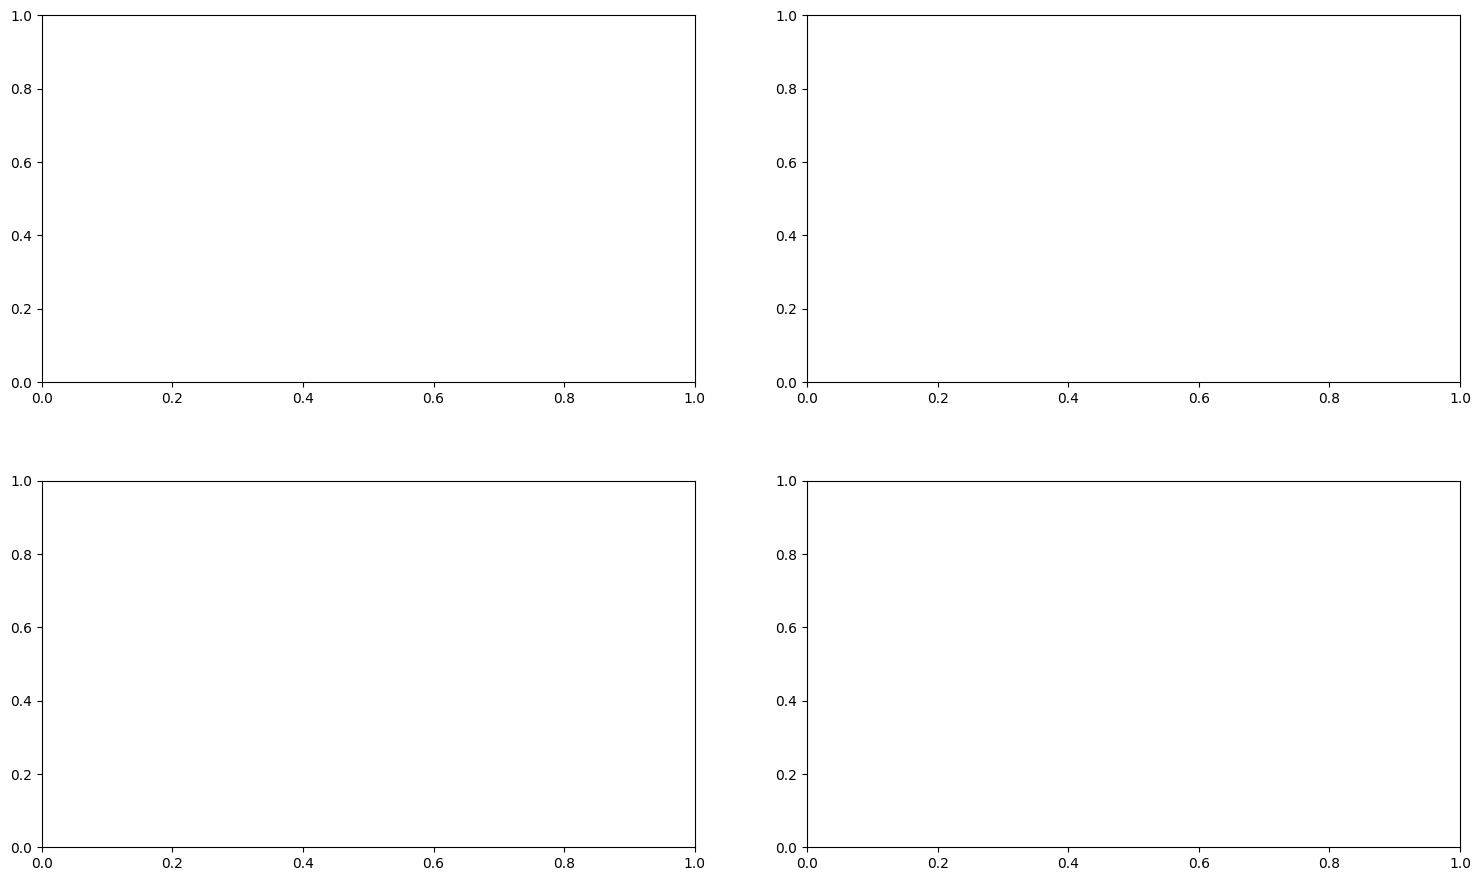

In [4]:
from RouteRL.services import plotter
plotter(params[kc.PLOTTER])